In [1]:
#imports

import requests
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer, ColumnTransformer

from sklearn.preprocessing import StandardScaler


In [2]:
df=pd.read_csv('../data/stemmed.csv')
df.head()

,Unnamed: 0,subreddit,text,tokenized,no_stopwords,stemmed,length
0,0,1,Simple slow run. :),"['simple', 'slow', 'run']",simple slow run,simpl slow run,4
1,1,1,Made a mini snowboard on my 3d printer,"['made', 'a', 'mini', 'snowboard', 'on', 'my',...",made mini 3d printer,made a mini snowboard on my 3d printer,8
2,2,1,Advise for a Snowboard to Buy,"['advise', 'for', 'a', 'snowboard', 'to', 'buy']",advise buy,advis for a snowboard to buy,6
3,3,1,Here are the brackets for NST at Revelstoke. ...,"['here', 'are', 'the', 'brackets', 'for', 'nst...",brackets nst revelstoke think matchups,here are the bracket for nst at revelstok what...,15
4,4,1,How to fall on boxes and rails?,"['how', 'to', 'fall', 'on', 'boxes', 'and', 'r...",fall boxes rails,how to fall on box and rail,7


In [3]:
df.dtypes

Unnamed: 0       int64
subreddit        int64
text            object
tokenized       object
no_stopwords    object
stemmed         object
length           int64
dtype: object

In [4]:
df=df.drop(columns='Unnamed: 0')


In [5]:
df.tail()

,subreddit,text,tokenized,no_stopwords,stemmed,length
9703,0,Flying into denver...\n\nI heard they have a s...,"['flying', 'into', 'denver', 'i', 'heard', 'th...",flying denver heard separate carousel true boo...,fli into denver i heard they have a separ caro...,51
9704,0,Hey guys! Do u think skiing with this core sh...,"['hey', 'guys', 'do', 'u', 'think', 'skiing', ...",hey guys u think core shot day damage permanen...,hey guy do u think ski with thi core shot for ...,38
9705,0,"Four season passes for Nozawa Onsen, Japan up...","['four', 'season', 'passes', 'for', 'nozawa', ...",four season passes nozawa onsen japan grabs,four season pass for nozawa onsen japan up for...,10
9706,0,New planks just came in.,"['new', 'planks', 'just', 'came', 'in']",new planks came,new plank just came in,5
9707,0,Little clip from today,"['little', 'clip', 'from', 'today']",little clip today,littl clip from today,4


In [6]:
df.isna().sum()

subreddit        0
text             0
tokenized        0
no_stopwords    37
stemmed         10
length           0
dtype: int64

In [7]:
#baseline, should be really close to 50
df['subreddit'].mean()

0.5002060156571899

# Naïve Bayes on text

In [8]:
X = df['text']
y = df['subreddit']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=23)

In [10]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [11]:
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [12]:
pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [13]:
gs = GridSearchCV(pipe, 
                  param_grid = pipe_params, 
                  cv = 5) 

In [14]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [15]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1)}

In [16]:
# trying again because we were hitting the extreme end of our ranges
pipe_params2 = {
    'cvec__max_features': [500, 1_000, 2_000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.7, .9],
    'cvec__ngram_range': [(1, 1)]
}

In [17]:
gs = GridSearchCV(pipe, 
                  param_grid = pipe_params2, 
                  cv = 5) 

In [18]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.7, 0.9],
                         'cvec__max_features': [500, 1000, 2000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1)]})

In [19]:
gs.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [20]:
gs.score(X_train, y_train)

0.7919241862381541

In [21]:
gs.score(X_test, y_test)

0.7552533992583437

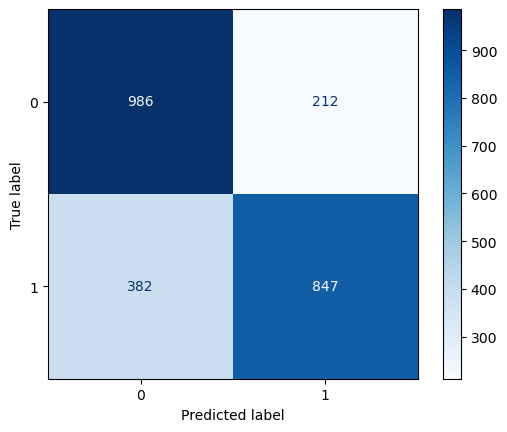

In [22]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap="Blues")

In [23]:
preds = gs.predict(X_test)

In [24]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [25]:
spec = tn / (tn + fp)

sens = tp / (tp + fn)

acc = (tp+tn) / (tp + tn+ fn+fp)

prec = tp/ (tp+fp)

print(f'Specificity: {spec}')

print(f'Sensitivity: {sens}')

print(f'Accuracy: {acc}')

print(f'Precision: {prec}')

Specificity: 0.8230383973288815
Sensitivity: 0.6891781936533767
Accuracy: 0.7552533992583437
Precision: 0.7998111425873465


# Naïve Bayes on No Stopwords

In [26]:
df.shape

(9708, 6)

In [27]:
df2=df[df['no_stopwords'].notnull()]
df2.shape

(9671, 6)

In [28]:
X = df2['no_stopwords']
y = df2['subreddit']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=23)

In [30]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [31]:
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [32]:
pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [33]:
gs = GridSearchCV(pipe, 
                  param_grid = pipe_params, 
                  cv = 5) 

In [34]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [35]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [36]:
# trying again because we were hitting the extreme end of our ranges
pipe_params2 = {
    'cvec__max_features': [500, 1_000, 2_000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.7, .9],
    'cvec__ngram_range': [(1, 1)]
}

In [37]:
gs = GridSearchCV(pipe, 
                  param_grid = pipe_params2, 
                  cv = 5) 

In [38]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.7, 0.9],
                         'cvec__max_features': [500, 1000, 2000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1)]})

In [39]:
gs.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [40]:
gs.score(X_train, y_train)

0.7094995174410589

In [41]:
gs.score(X_test, y_test)

0.6464019851116626

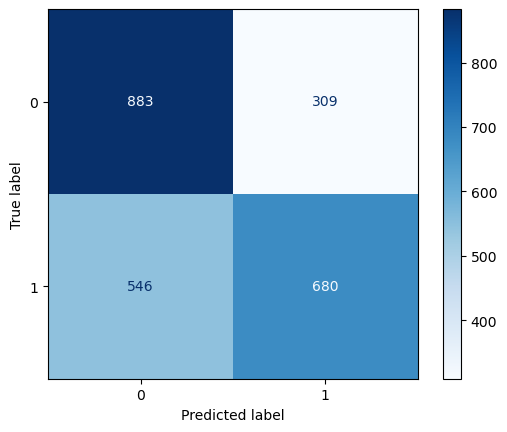

In [42]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap="Blues")

In [43]:
preds = gs.predict(X_test)

In [44]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [45]:
spec = tn / (tn + fp)

sens = tp / (tp + fn)

acc = (tp+tn) / (tp + tn+ fn+fp)

prec = tp/ (tp+fp)

print(f'Specificity: {spec}')

print(f'Sensitivity: {sens}')

print(f'Accuracy: {acc}')

print(f'Precision: {prec}')

Specificity: 0.7407718120805369
Sensitivity: 0.5546492659053833
Accuracy: 0.6464019851116626
Precision: 0.6875631951466128


# Naïve Bayes on stemmed

In [46]:
df3=df[df['stemmed'].notnull()]
df3.shape

(9698, 6)

In [47]:
X = df3['stemmed']
y = df3['subreddit']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=23)

In [49]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [50]:
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [51]:
pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [52]:
gs = GridSearchCV(pipe, 
                  param_grid = pipe_params, 
                  cv = 5) 

In [53]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [54]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [55]:
# trying again because we were hitting the extreme end of our ranges
pipe_params2 = {
    'cvec__max_features': [4_000],
    'cvec__min_df': [2,3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1)]
}

In [56]:
gs = GridSearchCV(pipe, 
                  param_grid = pipe_params2, 
                  cv = 5) 

In [57]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [4000], 'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1)]})

In [58]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [59]:
gs.score(X_train, y_train)

0.8186443008387185

In [60]:
gs.score(X_test, y_test)

0.7670103092783506

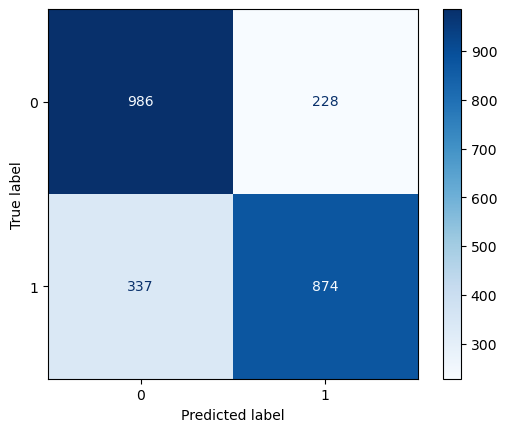

In [61]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap="Blues")

In [62]:
preds = gs.predict(X_test)

In [63]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [64]:
spec = tn / (tn + fp)

sens = tp / (tp + fn)

acc = (tp+tn) / (tp + tn+ fn+fp)

prec = tp/ (tp+fp)

print(f'Specificity: {spec}')

print(f'Sensitivity: {sens}')

print(f'Accuracy: {acc}')

print(f'Precision: {prec}')

Specificity: 0.8121911037891268
Sensitivity: 0.7217175887696119
Accuracy: 0.7670103092783506
Precision: 0.7931034482758621


coefs = model.named_steps["classifier"].coef_.flatten()# Logistic

In [65]:
df_lr=df[df['no_stopwords'].notnull()]

In [66]:
X=df_lr['no_stopwords']
y=df_lr['subreddit']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=23)

In [68]:
log_reg = Pipeline([
   ('cvec', CountVectorizer()),
   ('lr', LogisticRegression(random_state=23))
    ])


In [69]:
log_reg.fit(X_train, y_train)
log_reg.score(X_train, y_train)

0.8983868743968013

In [70]:
log_reg.score(X_test, y_test)

0.6807278742762614

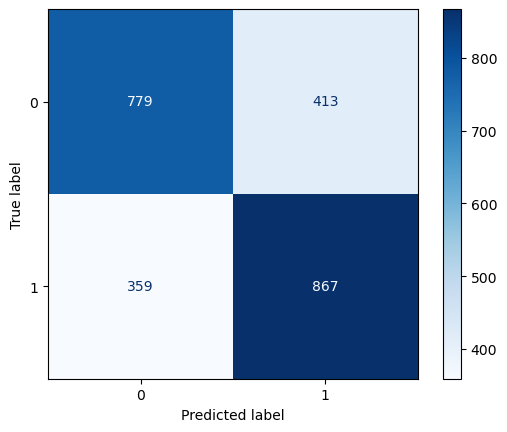

In [71]:
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test, cmap="Blues")

In [72]:
preds = log_reg.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [73]:
spec = tn / (tn + fp)

sens = tp / (tp + fn)

acc = (tp+tn) / (tp + tn+ fn+fp)

prec = tp/ (tp+fp)

print(f'Specificity: {spec}')

print(f'Sensitivity: {sens}')

print(f'Accuracy: {acc}')

print(f'Precision: {prec}')

Specificity: 0.6535234899328859
Sensitivity: 0.7071778140293637
Accuracy: 0.6807278742762614
Precision: 0.67734375


# Logistic Regression on text

In [74]:
df.shape

(9708, 6)

In [75]:
df.isna().sum()

subreddit        0
text             0
tokenized        0
no_stopwords    37
stemmed         10
length           0
dtype: int64

In [76]:
df_logreg=df.copy()

In [77]:
df_logreg.shape

(9708, 6)

In [78]:
X=df_logreg['text']
y=df_logreg['subreddit']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=23)

In [80]:
cvec =  CountVectorizer()

Z_train = cvec.fit_transform(X_train)
Z_test = cvec.transform(X_test)

In [81]:

logreg = LogisticRegression()
logreg.fit(Z_train,y_train)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [82]:
logreg.score(Z_train,y_train)


0.9435517099299546

In [83]:
logreg.score(Z_test,y_test)

0.7750309023485785

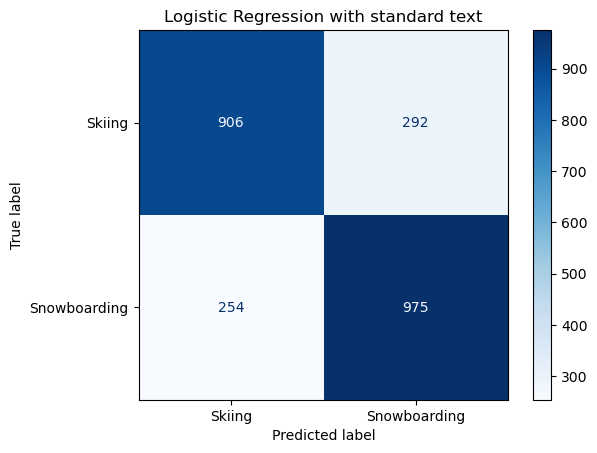

<Figure size 600x600 with 0 Axes>

In [84]:
ConfusionMatrixDisplay.from_estimator(logreg, Z_test, y_test, cmap="Blues", display_labels=('Skiing', 'Snowboarding'))
plt.title("Logistic Regression with standard text")
plt.figure(figsize=(6,6))
plt.savefig('../images/cm_logreg_text.png')

In [85]:
preds = logreg.predict(Z_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [86]:
spec = tn / (tn + fp)

sens = tp / (tp + fn)

acc = (tp+tn) / (tp + tn+ fn+fp)

prec = tp/ (tp+fp)

print(f'Specificity: {spec}')

print(f'Sensitivity: {sens}')

print(f'Accuracy: {acc}')

print(f'Precision: {prec}')

Specificity: 0.7562604340567612
Sensitivity: 0.7933279088689992
Accuracy: 0.7750309023485785
Precision: 0.7695343330702447


# inference on LogReg Text

In [87]:
logreg.coef_

array([[ 0.07636699, -0.02755631, -0.14572846, ..., -0.16866049,
        -0.15930705, -0.23546596]])

In [88]:
logreg.intercept_

array([0.33536385])

In [89]:
cvec.get_feature_names_out()

array(['00', '000', '000ft', ..., 'åre', 'êtes', 'ötztal'], dtype=object)

In [90]:
fm_df=pd.DataFrame({'feature' : cvec.get_feature_names(), 'coef' : logreg.coef_[0]}).sort_values(by='coef', ascending=False)
fm_df.head()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,coef
1554,board,4.069563
8258,snowboard,3.789448
8266,snowboarding,3.573687
1795,burton,2.873113
7461,riding,2.437210


In [91]:
fm_df['weight']=np.exp(fm_df['coef'])

In [92]:
fm_df.head()

,feature,coef,weight
1554,board,4.069563,58.531369
8258,snowboard,3.789448,44.231999
8266,snowboarding,3.573687,35.647772
1795,burton,2.873113,17.692012
7461,riding,2.437210,11.441077


In [93]:
fm_snow=fm_df.head(15).copy()
fm_ski=fm_df.tail(15).copy()

''

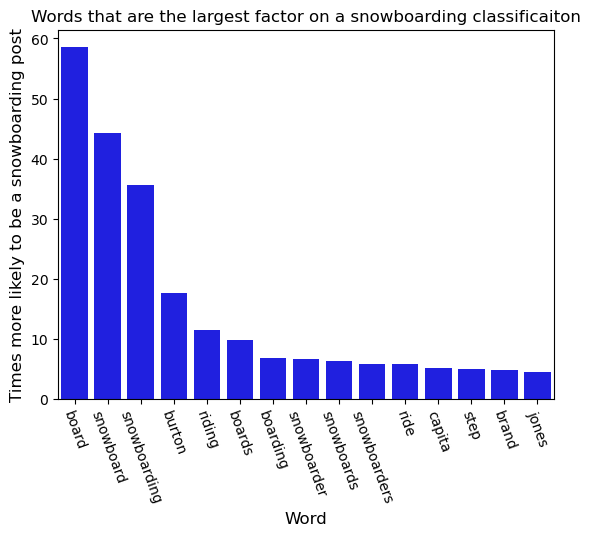

In [94]:
sns.barplot(x=fm_snow['feature'], y=fm_snow['weight'], color='blue')
plt.xticks(rotation=-70);

plt.title('Words that are the largest factor on a snowboarding classificaiton', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Times more likely to be a snowboarding post', fontsize=12)
plt.tick_params(labelsize=10)
plt.xticks(rotation=-70)
plt.savefig('../images/snow_weight_common.png')
;

''

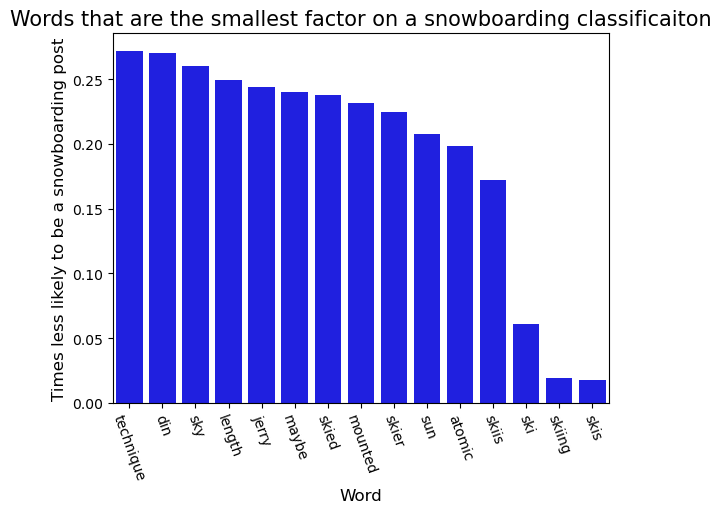

In [95]:
sns.barplot(x=fm_ski['feature'], y=fm_ski['weight'], color='blue')
plt.xticks(rotation=-70);

plt.title('Words that are the smallest factor on a snowboarding classificaiton', fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Times less likely to be a snowboarding post', fontsize=12)
plt.tick_params(labelsize=10)
plt.xticks(rotation=-70)
plt.savefig('../images/ski_weight_common.png')
;

# Logistic on no stopwords

In [96]:
df_logreg=df[df['no_stopwords'].notnull()]

In [97]:
X=df_logreg['no_stopwords']
y=df_logreg['subreddit']

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=23)

In [99]:
cvec =  CountVectorizer()

Z_train = cvec.fit_transform(X_train)
Z_test = cvec.transform(X_test)

In [100]:

logreg = LogisticRegression()
logreg.fit(Z_train,y_train)


LogisticRegression()

In [101]:
logreg.score(Z_train,y_train)


0.8983868743968013

In [102]:
logreg.score(Z_test,y_test)

0.6807278742762614

''

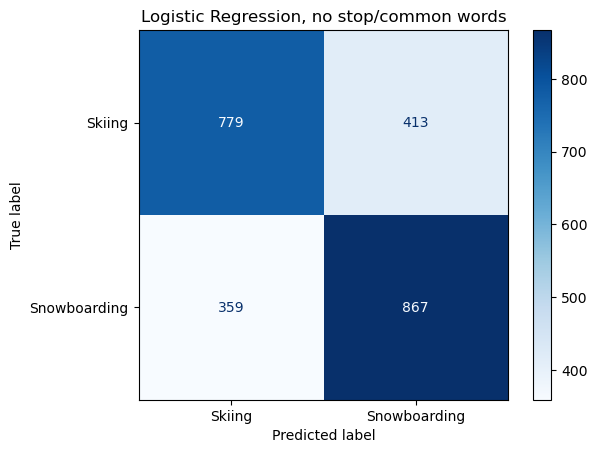

In [103]:
ConfusionMatrixDisplay.from_estimator(logreg, Z_test, y_test, cmap="Blues", display_labels=('Skiing', 'Snowboarding'))
plt.title("Logistic Regression, no stop/common words")
;

In [104]:
preds = logreg.predict(Z_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [105]:
spec = tn / (tn + fp)

sens = tp / (tp + fn)

acc = (tp+tn) / (tp + tn+ fn+fp)

prec = tp/ (tp+fp)

print(f'Specificity: {spec}')

print(f'Sensitivity: {sens}')

print(f'Accuracy: {acc}')

print(f'Precision: {prec}')

Specificity: 0.6535234899328859
Sensitivity: 0.7071778140293637
Accuracy: 0.6807278742762614
Precision: 0.67734375


# Interefence on logreg no stopwords

In [106]:
logreg.coef_

array([[ 0.09456035, -0.48055907, -0.17604432, ..., -0.03135019,
        -0.50061333, -0.26940011]])

In [107]:
logreg.intercept_

array([0.27296175])

In [108]:
cvec.get_feature_names_out()

array(['00', '000', '000ft', ..., 'zwitserland', 'åre', 'åreskutan'],
      dtype=object)

In [109]:
fm_df=pd.DataFrame({'feature' : cvec.get_feature_names(), 'coef' : logreg.coef_[0]}).sort_values(by='coef', ascending=False)
fm_df.head()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,coef
1744,burton,3.166114
7305,riding,2.255259
7293,ride,1.938101
1841,capita,1.863783
4825,jones,1.836969


In [110]:
fm_df['weight']=np.exp(fm_df['coef'])
fm_df.head()

,feature,coef,weight
1744,burton,3.166114,23.715145
7305,riding,2.255259,9.537761
7293,ride,1.938101,6.945546
1841,capita,1.863783,6.448083
4825,jones,1.836969,6.277484


In [111]:
fm_ski=fm_df.tail(15).copy()

In [112]:
fm_snow=fm_df.head(15).copy()

''

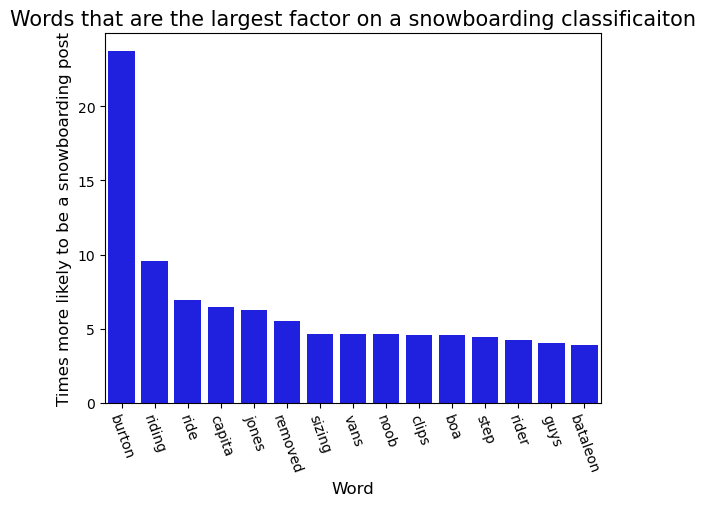

In [113]:
sns.barplot(x=fm_snow['feature'], y=fm_snow['weight'], color='blue')
plt.xticks(rotation=-70);

plt.title('Words that are the largest factor on a snowboarding classificaiton', fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Times more likely to be a snowboarding post', fontsize=12)
plt.tick_params(labelsize=10)
plt.xticks(rotation=-70)
plt.savefig('../images/snow_weight_no_common.png')

;

''

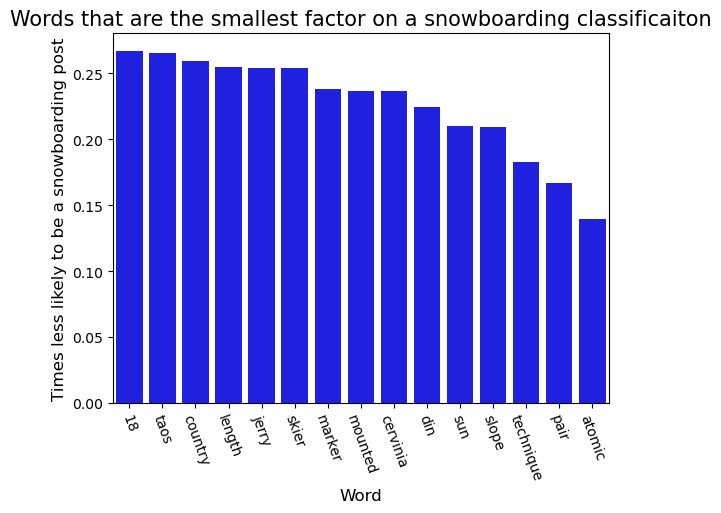

In [114]:
sns.barplot(x=fm_ski['feature'], y=fm_ski['weight'], color='blue')
plt.xticks(rotation=-70);

plt.title('Words that are the smallest factor on a snowboarding classificaiton', fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Times less likely to be a snowboarding post', fontsize=12)
plt.tick_params(labelsize=10)
plt.xticks(rotation=-70)
plt.savefig('../images/ski_weight_no_common.png')
;

#  Logistic Text,include text length

In [115]:
df_text=df[df['text'].notnull()]

In [116]:
df_text.head()

,subreddit,text,tokenized,no_stopwords,stemmed,length
0,1,Simple slow run. :),"['simple', 'slow', 'run']",simple slow run,simpl slow run,4
1,1,Made a mini snowboard on my 3d printer,"['made', 'a', 'mini', 'snowboard', 'on', 'my',...",made mini 3d printer,made a mini snowboard on my 3d printer,8
2,1,Advise for a Snowboard to Buy,"['advise', 'for', 'a', 'snowboard', 'to', 'buy']",advise buy,advis for a snowboard to buy,6
3,1,Here are the brackets for NST at Revelstoke. ...,"['here', 'are', 'the', 'brackets', 'for', 'nst...",brackets nst revelstoke think matchups,here are the bracket for nst at revelstok what...,15
4,1,How to fall on boxes and rails?,"['how', 'to', 'fall', 'on', 'boxes', 'and', 'r...",fall boxes rails,how to fall on box and rail,7


In [117]:
X=df_text['text']

In [118]:
cvec = CountVectorizer(stop_words= 'english')

In [119]:
cvec.fit(X)

CountVectorizer(stop_words='english')

In [120]:
X = cvec.transform(X)

In [121]:
X.shape

(9708, 11504)

In [122]:
X.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [123]:
X = pd.DataFrame(X.todense(), 
                          columns=cvec.get_feature_names())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [124]:
X.head()

,00,000,000ft,00am,01,02,03,04,05,05ish,...,zrddnty0wtq,zugspitze,zujtu9,zurs,zwitserland,zx100,åre,åreskutan,êtes,ötztal
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [125]:
df_vect=pd.concat([df,X], axis=1)


In [126]:
df_vect.head()

,subreddit,text,tokenized,no_stopwords,stemmed,length,00,000,000ft,00am,...,zrddnty0wtq,zugspitze,zujtu9,zurs,zwitserland,zx100,åre,åreskutan,êtes,ötztal
0,1,Simple slow run. :),"['simple', 'slow', 'run']",simple slow run,simpl slow run,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Made a mini snowboard on my 3d printer,"['made', 'a', 'mini', 'snowboard', 'on', 'my',...",made mini 3d printer,made a mini snowboard on my 3d printer,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,Advise for a Snowboard to Buy,"['advise', 'for', 'a', 'snowboard', 'to', 'buy']",advise buy,advis for a snowboard to buy,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,Here are the brackets for NST at Revelstoke. ...,"['here', 'are', 'the', 'brackets', 'for', 'nst...",brackets nst revelstoke think matchups,here are the bracket for nst at revelstok what...,15,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,How to fall on boxes and rails?,"['how', 'to', 'fall', 'on', 'boxes', 'and', 'r...",fall boxes rails,how to fall on box and rail,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
X=df_vect.drop(columns=['subreddit', 'text', 'tokenized', 'no_stopwords','stemmed'])
y=df_text['subreddit']

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=23)

In [129]:

logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train,y_train)


LogisticRegression(solver='liblinear')

In [130]:
logreg.score(X_train,y_train)


0.9376459277571763

In [131]:
logreg.score(X_test,y_test)

0.7737948084054388

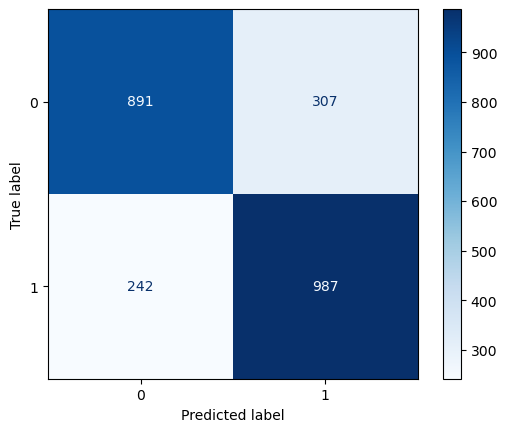

In [132]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test, cmap="Blues")


In [133]:
preds = logreg.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [134]:
spec = tn / (tn + fp)

sens = tp / (tp + fn)

acc = (tp+tn) / (tp + tn+ fn+fp)

prec = tp/ (tp+fp)

print(f'Specificity: {spec}')

print(f'Sensitivity: {sens}')

print(f'Accuracy: {acc}')

print(f'Precision: {prec}')

Specificity: 0.7437395659432388
Sensitivity: 0.8030919446704637
Accuracy: 0.7737948084054388
Precision: 0.7627511591962906


#  Logistic no Stopwords,include text length

In [135]:
df_logregNS=df[df['no_stopwords'].notnull()]

In [136]:
df_logregNS.isnull().sum()

subreddit       0
text            0
tokenized       0
no_stopwords    0
stemmed         0
length          0
dtype: int64

In [137]:
X=df_logregNS['no_stopwords']

In [138]:
cvec = CountVectorizer(stop_words= 'english')

In [139]:
cvec.fit(X)

CountVectorizer(stop_words='english')

In [140]:
X = cvec.transform(X)

In [141]:
X.shape

(9671, 11467)

In [142]:
X.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [143]:
X = pd.DataFrame(X.todense(), 
                          columns=cvec.get_feature_names())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [144]:
X.head()

,00,000,000ft,00am,01,02,03,04,05,05ish,...,zrddnty0wtq,zugspitze,zujtu9,zurs,zwitserland,zx100,åre,åreskutan,êtes,ötztal
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [145]:
df_vect=pd.concat([df_logregNS,X], axis=1)


In [146]:
df_vect.head()

,subreddit,text,tokenized,no_stopwords,stemmed,length,00,000,000ft,00am,...,zrddnty0wtq,zugspitze,zujtu9,zurs,zwitserland,zx100,åre,åreskutan,êtes,ötztal
0,1.0,Simple slow run. :),"['simple', 'slow', 'run']",simple slow run,simpl slow run,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,Made a mini snowboard on my 3d printer,"['made', 'a', 'mini', 'snowboard', 'on', 'my',...",made mini 3d printer,made a mini snowboard on my 3d printer,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,Advise for a Snowboard to Buy,"['advise', 'for', 'a', 'snowboard', 'to', 'buy']",advise buy,advis for a snowboard to buy,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,Here are the brackets for NST at Revelstoke. ...,"['here', 'are', 'the', 'brackets', 'for', 'nst...",brackets nst revelstoke think matchups,here are the bracket for nst at revelstok what...,15.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,How to fall on boxes and rails?,"['how', 'to', 'fall', 'on', 'boxes', 'and', 'r...",fall boxes rails,how to fall on box and rail,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
X=df_logregNS.drop(columns=['subreddit', 'text', 'tokenized', 'no_stopwords','stemmed'])
y=df_logregNS['subreddit']

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=23)

In [149]:

logreg = LogisticRegression()
logreg.fit(X_train,y_train)


LogisticRegression()

In [150]:
logreg.score(X_train,y_train)


0.5618364814559492

In [151]:
logreg.score(X_test,y_test)

0.5603804797353185

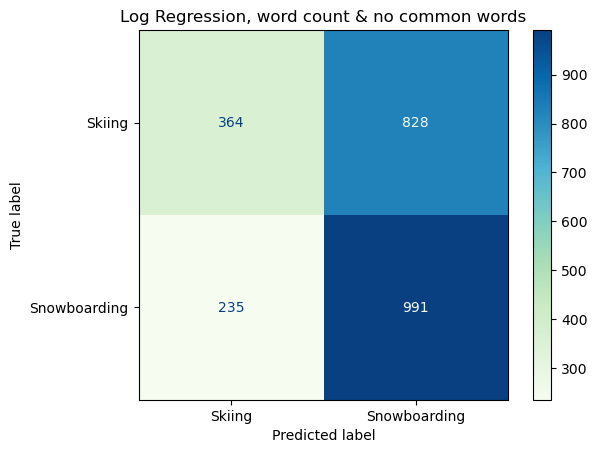

<Figure size 600x600 with 0 Axes>

In [152]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test, cmap="GnBu",  display_labels=('Skiing', 'Snowboarding')) 
plt.title("Log Regression, word count & no common words")
plt.figure(figsize=(6,6))
plt.savefig('../images/cm_logreg_stemmed_length.png')

In [153]:
preds = logreg.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [154]:
spec = tn / (tn + fp)

sens = tp / (tp + fn)

acc = (tp+tn) / (tp + tn+ fn+fp)

prec = tp/ (tp+fp)

print(f'Specificity: {spec}')

print(f'Sensitivity: {sens}')

print(f'Accuracy: {acc}')

print(f'Precision: {prec}')

Specificity: 0.3053691275167785
Sensitivity: 0.8083197389885808
Accuracy: 0.5603804797353185
Precision: 0.5448048378229796


# LogReg Stem words with word count

In [155]:
df_logregSL=df[df['stemmed'].notnull()]

In [156]:
df_logregSL.isna().sum()

subreddit        0
text             0
tokenized        0
no_stopwords    27
stemmed          0
length           0
dtype: int64

In [157]:
X=df_logregSL['stemmed']

In [158]:
cvec = CountVectorizer()

In [159]:
cvec.fit(X)

CountVectorizer()

In [160]:
X = cvec.transform(X)

In [161]:
X.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [162]:
X = pd.DataFrame(X.todense(), 
                          columns=cvec.get_feature_names())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [163]:
X.shape

(9698, 8775)

In [164]:
X = X.drop('subreddit', axis=1)

In [165]:
df_logregSL.shape

(9698, 6)

In [166]:
df_logregSL=df_logregSL.reset_index(drop=True)

In [167]:
X=X.reset_index(drop=True)

In [168]:
df_stem=pd.concat([df_logregSL,X], axis=1)


In [169]:
X=df_stem.drop(columns=['subreddit', 'text', 'tokenized', 'no_stopwords','stemmed'])
y=df_stem['subreddit']

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=23)

In [171]:

logreg = LogisticRegression()
logreg.fit(X_train,y_train)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [172]:
logreg.score(X_train,y_train)


0.8964663825106558

In [173]:
logreg.score(X_test,y_test)

0.7872164948453608

Text(0.5, 1.0, 'Logistic Regression, stemmed words and word count')

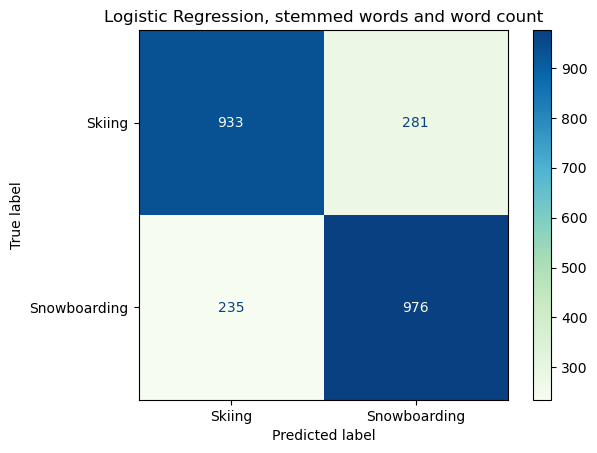

In [174]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test, cmap="GnBu",  display_labels=('Skiing', 'Snowboarding')) 
plt.title("Logistic Regression, stemmed words and word count")

In [175]:
preds = logreg.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [176]:
spec = tn / (tn + fp)

sens = tp / (tp + fn)

acc = (tp+tn) / (tp + tn+ fn+fp)

prec = tp/ (tp+fp)

print(f'Specificity: {spec}')

print(f'Sensitivity: {sens}')

print(f'Accuracy: {acc}')

print(f'Precision: {prec}')

Specificity: 0.7685337726523888
Sensitivity: 0.805945499587118
Accuracy: 0.7872164948453608
Precision: 0.7764518695306285
